In this script we tried to detect the most promising co-formers to be tested for co-crystalization with pyrene.
The parameters that are taken into consideration are optimized using Pareto Front.
Optimized parameters: **1)** score of the model and **2)** similarity to TCQN


In [ ]:
# Import the main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
# Install the RDKit library
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

# Append rdkit path to current python system path
%matplotlib inline
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
#Import thr RDKit fuctionalities
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
# Import the relevant datasets
# Import the file with the scores for the predicted pyrene co-crystals
scores=pd.read_csv('/content/drive/My Drive/cocrystal_design/data/pyrene_pairs_scores8.csv',  encoding= 'unicode_escape')
k = scores.smiles
v = scores.score
scores_dict= {key:value for key, value in zip(k, v)}

#Import the file with the prices and number of reported co-crystals
# Keep only those that are avaible (remove nan values) and have price lower than £200/1g
data=pd.read_csv('/content/drive/My Drive/cocrystal_design/data/pyrene_cocrystals.csv',  encoding= 'unicode_escape')
data =data.iloc[:, :-3]
data=data.dropna()
data = data[data['price(/1g)'].astype(float) < 200]

scores=[]
for i in data.smiles:
  scores.append(scores_dict[i])
data =  pd.concat([pd.DataFrame(data.values, columns=data.columns.values), pd.DataFrame(scores, columns=['scores'])], axis=1)
data

,smiles,price(/1g),number_of_cocrystals,scores
0,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56,112,3,0.795262
1,c1cc2ccc3ccc4ccc5ccc6ccc1c7c6c5c4c3c27,181,58,0.801541
2,C1=Cc2cccc3cccc1c23,10,1,0.794998
3,c1cc2cccc3c4cccc5cccc(c(c1)c23)c45,44,101,0.823077
4,c1ccc2c(c1)ccc3ccc4ccccc4c23,61.69,1,0.817668
...,...,...,...,...
79,o1c2ccccc2c3ccccc13,0.72,3,0.636692
80,c1ccc(cc1)[S+](c2ccccc2)c3ccccc3,170,9,0.000000
81,C[n+]1c2ccccc2c(c3c4ccccc4[n+](C)c5ccccc35)c6c...,67,0,0.568886
82,[O-][N+](=O)c1cc(c2ccccc2c1)[N+](=O)[O-],50.2,0,0.561715


In [164]:
# Make the number of co-crystals column binary, either have known co-crystals 1 or not 0.
data_tot = pd.concat([ pd.DataFrame(data.values, columns = data.columns.values)], axis=1)
data_tot = data_tot.dropna()
data_tot['number_of_cocrystals'][data_tot['number_of_cocrystals'] != '0'] = 1

In [165]:
# Calculate electronic similarity to TCQN

def c(l1, l2):
  return DataStructs.TanimotoSimilarity(l1,l2)

def tanimoto_distance():
  coform1 = data_tot.smiles
  coform2 = ['N#CC(C#N)=c1ccc(=C(C#N)C#N)cc1']
  lista1=[]
  for i in coform1.values:
    lista1.append(Chem.MolFromSmiles(i))
  lista1 = [x for x in lista1 if x is not None]

  lista2=[]
  for i in coform2:
    lista2.append(Chem.MolFromSmiles(i))
  lista2 = [x for x in lista2 if x is not None]
  fps =  [AllChem.GetMorganFingerprint(x,2) for x in lista1]
  fps2 =  [AllChem.GetMorganFingerprint(x,2) for x in lista2]
  dis= []
  distance = []
  for i in range(len(fps)):
    for j in range(len(fps2)):
      distance = c(fps[i], fps2[j])
      dis.append({'csd_molecules': coform1.values[i], 'zinc_molecules': coform2[j], 'distance': distance})
  df=pd.DataFrame(dis)
  return df

In [166]:
# Add the tanimoto distance to the dataset
df = tanimoto_distance()
data_tot['distance'] = df.distance
data_tot

,smiles,price(/1g),number_of_cocrystals,scores,distance
0,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56,112,1,0.795262,0.100000
1,c1cc2ccc3ccc4ccc5ccc6ccc1c7c6c5c4c3c27,181,1,0.801541,0.094340
2,C1=Cc2cccc3cccc1c23,10,1,0.794998,0.142857
3,c1cc2cccc3c4cccc5cccc(c(c1)c23)c45,44,1,0.823077,0.106383
4,c1ccc2c(c1)ccc3ccc4ccccc4c23,61.69,1,0.817668,0.113636
...,...,...,...,...,...
79,o1c2ccccc2c3ccccc13,0.72,1,0.636692,0.136986
80,c1ccc(cc1)[S+](c2ccccc2)c3ccccc3,170,1,0,0.109890
81,C[n+]1c2ccccc2c(c3c4ccccc4[n+](C)c5ccccc35)c6c...,67,0,0.568886,0.081967
82,[O-][N+](=O)c1cc(c2ccccc2c1)[N+](=O)[O-],50.2,0,0.561715,0.100000


In [ ]:
# Code for calculating the Pareto frontier for the molecules that have not been reported as co-formers before
# The optimization is performed using two parameters: score and tanimoto similarity to TCNQ

def pareto_frontier(Xs, Ys, maxX = True, maxY = True):
# Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
# Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]    
# Loop through the sorted list
    for pair in myList[1:]:
        if maxY: 
            if pair[1] >= p_front[-1][1]: # Look for higher values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
        else:
            if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
# Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY


In [ ]:
no = data_tot[data_tot['number_of_cocrystals'].astype('int').values == 0]
yes = data_tot[data_tot['number_of_cocrystals'].astype('int').values == 1]
scores = pd.concat([no.scores, no.distance], axis=1)
scores = scores.values

In [ ]:
# Get the parameters for the experimentally tested molecules
one = data_tot[data_tot.smiles == 'O=C1Oc2ccccc2c3ccccc13']
two = data_tot[data_tot.smiles == 'N#Cc1c2ccccc2c(C#N)c3ccccc13' ]
three=  data_tot[data_tot.smiles == 'O=C1CCCc2ccc3ccccc3c12' ]
four=  data_tot[data_tot.smiles == 'C=Cc1cccc2ccccc12' ]
five=  data_tot[data_tot.smiles == 'c1ccc(cc1)c2c3ccccc3cc4ccccc24' ]
six =  data_tot[data_tot.smiles == 'c1ccc2c3ccccc3c4ccccc4c2c1' ]

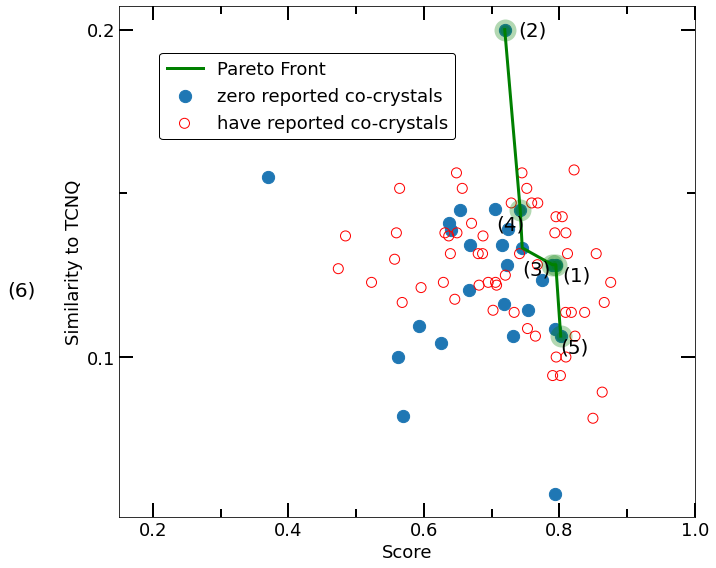

In [ ]:
import matplotlib.pyplot as plt   
from matplotlib import rcParams
from matplotlib.lines import Line2D
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'

fig = plt.figure(figsize=(10,8)) 
ax = fig.add_subplot(111)#, aspect='equal')
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
ax.set_xlim(0.15, 1)
major_ticks_x = np.arange(0.2, 1.1, 0.2)
minor_ticks_x = np.arange(0.2, 1.1, 0.1)
major_ticks_y = np.arange(0, 0.3, 0.1)
minor_ticks_y = np.arange(0, 0.3, 0.05)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)

 
no = data_tot[data_tot['number_of_cocrystals'].astype('int').values == 0]
yes = data_tot[data_tot['number_of_cocrystals'].astype('int').values == 1]
Xs, Ys = no.scores.values, no.distance.values
# Find lowest values for cost and highest for savings
p_front = pareto_frontier(Xs, Ys, maxX = True, maxY = True) 


plt.scatter(Xs, Ys, s=150, label='zero reported co-crystals')

plt.scatter( one.scores , one.distance, s=100, marker="o", linewidths=12, alpha=0.3, color='g')
plt.text(one.scores+0.01 , one.distance-0.005,  r'(1)', fontsize=20, color='black')

plt.scatter( yes.scores , yes.distance,  facecolors='none', edgecolors='r',  s=100, label='have reported co-crystals')

plt.scatter( two.scores , two.distance, s=100, marker="o", linewidths=12, alpha=0.3,  color='g')
plt.text(two.scores+0.02 , two.distance-0.002,  r'(2)', fontsize=20, color='black')

plt.scatter( three.scores , three.distance, s=100, marker="o", linewidths=12, alpha=0.3,  color='g')
plt.text(three.scores-0.045 , three.distance-0.003,  r'(3)', fontsize=20, color='black')

plt.scatter( four.scores , four.distance, s=100, marker="o", linewidths=12, alpha=0.3,  color='g')
plt.text(four.scores-0.035 , four.distance-0.006,  r'(4)', fontsize=20, color='black')

plt.scatter( five.scores , five.distance, s=100, marker="o", linewidths=12, alpha=0.3,  color='g')
plt.text(five.scores , five.distance-0.005,  r'(5)', fontsize=20, color='black')

plt.scatter( six.scores , six.distance, s=100, marker="o", linewidths=12, alpha=0.3,  color='g')
plt.text(six.scores-0.015 , six.distance+0.005,  r'(6)', fontsize=20, color='black')

# Then plot the Pareto frontier on top
plt.plot(p_front[0], p_front[1], label='Pareto Front', linewidth=3, color='green')
plt.xlabel('Score', fontsize=18)
plt.ylabel('Similarity to TCNQ', fontsize=18)
plt.legend(fontsize=18, loc=(0.07 ,0.74), framealpha=1, edgecolor='black')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('pareto.svg', dpi=600, rasterized=True,bbox_inches = "tight")
plt.tight_layout()
plt.show()

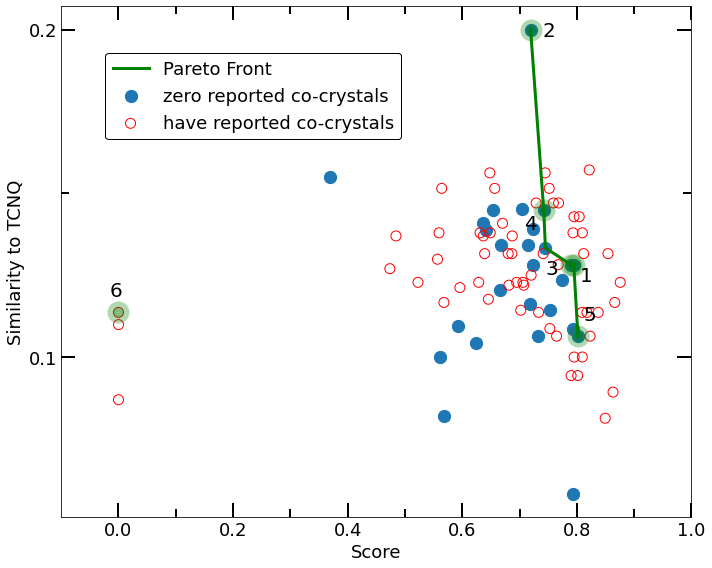

In [ ]:
import matplotlib.pyplot as plt   
from matplotlib import rcParams
from matplotlib.lines import Line2D
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'

fig = plt.figure(figsize=(10,8)) 
ax = fig.add_subplot(111)#, aspect='equal')
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
ax.set_xlim(-0.1, 1)
major_ticks_x = np.arange(0, 1.1, 0.2)
minor_ticks_x = np.arange(0, 1.1, 0.1)
major_ticks_y = np.arange(0, 0.3, 0.1)
minor_ticks_y = np.arange(0, 0.3, 0.05)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)

 
no = data_tot[data_tot['number_of_cocrystals'].astype('int').values == 0]
yes = data_tot[data_tot['number_of_cocrystals'].astype('int').values == 1]
Xs, Ys = no.scores.values, no.distance.values

# Find lowest values for cost and highest for savings
p_front = pareto_frontier(Xs, Ys, maxX = True, maxY = True) 
# Plot a scatter graph of all results

plt.scatter(Xs, Ys, s=150, label='zero reported co-crystals')

plt.scatter( one.scores , one.distance, s=100, marker="o", linewidths=12, alpha=0.3, color='g')
plt.text(one.scores+0.01 , one.distance-0.005,  r'1', fontsize=20, color='black')

plt.scatter( yes.scores , yes.distance,  facecolors='none', edgecolors='r',  s=100, label='have reported co-crystals')

plt.scatter( two.scores , two.distance, s=100, marker="o", linewidths=12, alpha=0.3,  color='g')
plt.text(two.scores+0.02 , two.distance-0.002,  r'2', fontsize=20, color='black')

plt.scatter( three.scores , three.distance, s=100, marker="o", linewidths=12, alpha=0.3,  color='g')
plt.text(three.scores-0.045 , three.distance-0.003,  r'3', fontsize=20, color='black')

plt.scatter( four.scores , four.distance, s=100, marker="o", linewidths=12, alpha=0.3,  color='g')
plt.text(four.scores-0.035 , four.distance-0.006,  r'4', fontsize=20, color='black')

plt.scatter( five.scores , five.distance, s=100, marker="o", linewidths=12, alpha=0.3,  color='g')
plt.text(five.scores+0.01 , five.distance+0.005,  r'5', fontsize=20, color='black')

plt.scatter( six.scores , six.distance, s=100, marker="o", linewidths=12, alpha=0.3,  color='g')
plt.text(six.scores-0.015 , six.distance+0.005,  r'6', fontsize=20, color='black')

# Then plot the Pareto frontier on top
plt.plot(p_front[0], p_front[1], label='Pareto Front', linewidth=3, color='green')
plt.xlabel('Score', fontsize=18)
plt.ylabel('Similarity to TCNQ', fontsize=18)
plt.legend(fontsize=18, loc=(0.07 ,0.74), framealpha=1, edgecolor='black')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.savefig('pareto.svg', dpi=600, rasterized=True,bbox_inches = "tight")
plt.tight_layout()
plt.show()